In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from datetime import datetime

In [2]:
image = cv2.imread('./DataSet/Green/2.jpg')

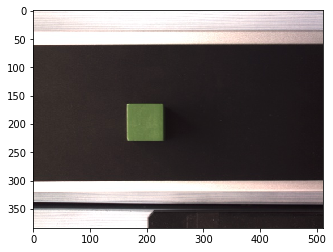

In [3]:
plt.imshow(image)

In [4]:
class Detect:
    def __init__(self):
        self.Lower = np.array([
            [156, 43, 46], #red lower bound
            [26, 43, 46], #yellow lower bound
            [105, 100, 100], #blue lower bound
            [35, 43, 46] #green lower bound
        ])

        self.Upper = np.array([
            [179, 255, 255],  # red upper bound
            [34, 255, 255],  # yellow upper bound
            [120, 255, 255],  # blue upper bound
            [80, 255, 255]  # green upper bound
        ])

        self.classes = self.Lower.shape[0]
        self.mapping = {1: 'red', 2: 'yellow', 3: 'blue', 4: 'green'}
    def find_bbox(self, image, lower, upper):
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        mask = cv2.inRange(hsv_image, lower, upper)
        ret, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
        kernel = np.ones((15, 15), np.uint8)
        dilation = cv2.dilate(binary, kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            boxes = [cv2.boundingRect(contour) for contour in contours]
            return np.array(boxes)
        else:
            return None

    def detect(self, image):
        result = np.empty(shape=[0, 5])

        for i in range(self.classes):
            lower = self.Lower[i]
            upper = self.Upper[i]

            bbox = self.find_bbox(image, lower, upper)
            if bbox is not None:
                for j in range(bbox.shape[0]):
                    temp = np.append(bbox[j], [i+1])
                    result = np.append(result, [temp], axis=0)
        if result.shape[0] != 0:
            # import ipdb; ipdb.set_trace()
            index = np.where(result[:, 2] == result[:, 2].max())[0][0]
            result_bbox = result[index]
            x, y, w, h, cls = result_bbox[:5]
            cv2.rectangle(image, (np.int(x), np.int(y)), (np.int(x + w), np.int(y + h)), (153, 153, 0), 2)
            cx = x + w // 2
            cy = y + h // 2
            return [cx,cy,w,h,cls] # return center coordinate & weight, height & class
        else:
            return None


In [10]:
class Rectify:
    def __init__(self, output):
        self.v = 0 # initial_v = 0
        self.time = output[0] #str
        self.cx = float(output[1])
        self.cy = float(output[2])
        self.w = float(output[3])
        self.h = float(output[4])
    def show(self):
        print('cx=',self.cx)
        print('cy=',self.cy)
        print('w=',self.w)
        print('h=',self.h)
    def Get_real_loc(self,parameters):
        X_pixel = (parameters[1] - parameters[0])/image.shape[1]
        Y_pixel = (parameters[3] - parameters[2])/image.shape[0]
        Real_X = X_pixel*self.cx+parameters[0]
        Real_Y = Y_pixel*self.cy+parameters[2]
        Real_W = X_pixel*self.w
        Real_H = Y_pixel*self.h
        return [Real_X,Real_Y,Real_W,Real_H]
    def Compute_V(self):
        return self.v
    # Kalman Filter
    def KF(self):
        return self.v

In [11]:
# param
left_x=10
right_x=50
up_y=10
bottom_y=50
print(image.shape)

(384, 512, 3)


In [12]:
detection = Detect()
timeStamp = datetime.now().timestamp()
back = detection.detect(image)
if back != None:
    x, y, w, h, cls = back
    outputlist = [timeStamp, x, y, w, h, detection.mapping[cls]]
    outputstr = " ".join(list(map(lambda x: str(x), outputlist)))
    print(outputstr)
else:
    print("no block found!\n")
    
Rec = Rectify(outputlist)
parameters=left_x, right_x, up_y, bottom_y
loc = Rec.Get_real_loc(parameters)
print("木块真实位置：",loc)


1576223682.170135 199.0 197.0 78.0 81.0 green
木块真实位置： [25.546875, 30.520833333333336, 6.09375, 8.4375]
